In [1]:
import osmium as osm
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import cv2

In [2]:
im_path = 'C:/Users/sgtas/Desktop/autonomous_car/ASTGTMV003_N36W122/ASTGTMV003_N36W122_dem.tif'
dted = cv2.imread(im_path,-1)

i_min = np.min(np.min(dted))
i_max = np.max(np.max(dted))

print("i_min: ", i_min)
print("i_max: ", i_max)

dted_im = (dted - i_min) / (i_max)

# cv2.namedWindow("im", cv2.WINDOW_NORMAL)
# cv2.imshow("im", dted_im)
# cv2.resizeWindow("im", 800, 800)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

i_min:  0
i_max:  1781


In [3]:
# make some useful functions
def haversine(lat1, lon1, lat2, lon2):
      R = 6372.8 #km
      dLat = math.radians(lat2 - lat1)
      dLon = math.radians(lon2 - lon1)
      lat1 = math.radians(lat1)
      lat2 = math.radians(lat2)
      a = math.sin(dLat/2)**2 + math.cos(lat1)*math.cos(lat2)*math.sin(dLon/2)**2
      c = 2*math.asin(math.sqrt(a))
      return R * c

def bearing(lat1, lon1, lat2, lon2):
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    Bearing = math.atan2(math.sin(dlon)*math.cos(lat2), 
                         math.cos(lat1)*math.sin(lat2)-math.sin(lat1)*math.cos(lat2)*math.cos(dlon))

    return Bearing

# function to get altitide
def get_alt_at_ll(dted, lat, lon):
    dlat = 1.0 - (lat - 36.0)
    dlon = lon - -122.0
    n_pix = dted.shape[0]
    deg_step = 1.0 / n_pix
        
    p_lat = int(n_pix * dlat)
    p_lon = int(n_pix * dlon)
    
    deltas = [-1,0,-1]
    sum_num = 0.0
    sum_den = 0.0
    for xi in deltas:
        for yi in deltas:
            s_lon = -122.0 + (p_lon+xi)*deg_step
            s_lat = 36.0 + (p_lat+yi)*deg_step
            s_alt = dted[int(p_lat + yi), int(p_lon + xi)]
            dist = haversine(s_lat, s_lon, lat, lon)
            sum_num += s_alt / dist
            sum_den += 1/dist
            
    return sum_num / sum_den
    
print("mountain: ", get_alt_at_ll(dted, 36.75542852349497, -121.51876894774158)) # 851 meters
print("coast: ", get_alt_at_ll(dted,36.85814823561437, -121.8066664643844))

mountain:  850.2229060477988
coast:  10.666580551558164


In [4]:
# class to parse the osm file
class OSMHandler(osm.SimpleHandler):
    def __init__(self):
        osm.SimpleHandler.__init__(self)
        self.way_data = []
        self.node_data = []

    def way_inventory(self, elem, elem_type):
        # print("elem.tags:" , elem.tags)
        for tag in elem.tags:
            if tag.k == 'name' and tag.v == 'WeatherTech Raceway Laguna Seca':
                # print("elem.nodes: ", elem.nodes[0].ref)
                nis = []
                for ni in elem.nodes:
                    # print("ni: ", ni)
                    nis.append(ni.ref)
                self.way_data.append([elem_type,
                                    tag.v,
                                    elem.id,
                                    nis])
                
    def node_inventory(self, elem, elem_type):
        self.node_data.append([int(elem.id), float(elem.location.lon), float(elem.location.lat)])

    def node(self, n):
        self.node_inventory(n, "node")

    def way(self, w):
        self.way_inventory(w, "way")

    # def relation(self, r):
    #     self.tag_inventory(r, "relation")

In [5]:
# parse the osm file
osmhandler = OSMHandler()
# scan the input file and fills the handler list accordingly
osmhandler.apply_file("C:/Users\sgtas/Desktop/autonomous_car/laguna_seca.osm")

# transform the list into a pandas DataFrame
way_df = pd.DataFrame(osmhandler.way_data, columns=['type', 'name', 'id', 'nodes'])
node_df = pd.DataFrame(osmhandler.node_data, columns=['id', 'lon', 'lat'])

print(node_df)

               id         lon        lat
0        89676188 -121.756883  36.584826
1        89745712 -121.748991  36.584789
2        89745714 -121.748453  36.585474
3        89797136 -121.760805  36.585302
4        89797137 -121.760810  36.585117
...           ...         ...        ...
7823   9789157460 -121.766167  36.581266
7824   9789157461 -121.766218  36.581279
7825  10023402099 -121.755879  36.569427
7826  10023402100 -121.755843  36.569489
7827  10178905526 -121.731942  36.649855

[7828 rows x 3 columns]


In [6]:
# get node lat/lon onlyon the race track
ls_nodes = []
for nid in way_df.iloc[0]['nodes']:
    temp = node_df.loc[node_df['id'] == nid]
    # ls_nodes.append([nid, temp["lon"].to_list()[0], temp["lat"].to_list()[0]])
    ls_nodes.append([temp["lon"].to_list()[0], temp["lat"].to_list()[0]])
    
    
# ls_df = pd.DataFrame(ls_nodes, columns=['id', 'lon', 'lat'])
ls_df = pd.DataFrame(ls_nodes, columns=['lon', 'lat'])
ls_df

,lon,lat
0,-121.756668,36.584947
1,-121.756604,36.584963
2,-121.756539,36.584971
3,-121.756473,36.584970
4,-121.756408,36.584964
...,...,...
201,-121.756883,36.584826
202,-121.756838,36.584863
203,-121.756786,36.584897
204,-121.756729,36.584926


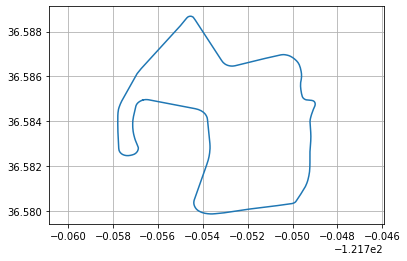

In [7]:
# plot it
plt.plot(ls_df["lon"], ls_df["lat"])
plt.axis('equal')
plt.grid()
plt.show()

In [8]:
# convert to meters based upon the center point of the course
m_lon = ls_df["lon"].mean()
m_lat = ls_df["lat"].mean()

ls_df["dist2center"] = ls_df.apply(lambda x: 1000.0 * haversine(x["lat"], x["lon"], m_lat, m_lon), axis=1)
ls_df["bearing2center"] = ls_df.apply(lambda x: bearing(m_lat, m_lon, x["lat"], x["lon"]), axis=1)
ls_df["x"] = ls_df.apply(lambda x: math.sin(x["bearing2center"]) * x["dist2center"], axis=1)
ls_df["y"] = ls_df.apply(lambda x: math.cos(x["bearing2center"]) * x["dist2center"], axis=1)
ls_df["z"] = ls_df.apply(lambda x: get_alt_at_ll(dted, x["lat"], x["lon"]), axis=1)
ls_df

,lon,lat,dist2center,bearing2center,x,y,z
0,-121.756668,36.584947,318.201459,-1.223633,-299.218092,108.262191,231.443840
1,-121.756604,36.584963,313.433786,-1.212333,-293.511005,109.963757,231.443840
2,-121.756539,36.584971,308.288948,-1.202828,-287.652116,110.897860,231.443840
3,-121.756473,36.584970,302.805458,-1.196232,-281.811125,110.786440,231.443840
4,-121.756408,36.584964,297.091949,-1.191363,-275.961224,110.041034,231.221014
...,...,...,...,...,...,...,...
201,-121.756883,36.584826,332.198096,-1.281597,-318.402783,94.737758,237.111229
202,-121.756838,36.584863,329.590961,-1.266110,-314.410385,98.875231,238.110502
203,-121.756786,36.584897,326.336765,-1.250754,-309.766026,102.667880,238.110502
204,-121.756729,36.584926,322.509253,-1.236431,-304.648340,105.837648,231.443840


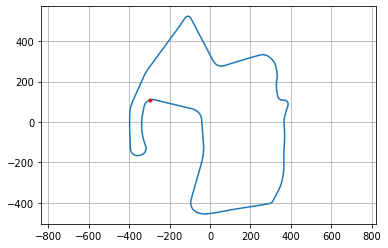

In [9]:
plt.plot(ls_df["x"], ls_df["y"])
plt.plot(ls_df["x"][0], ls_df["y"][0], 'r.')

plt.axis('equal')
plt.grid()
plt.show()


In [10]:
# convert to a path
path = []

temp = ls_df.shift(-1)
temp.iloc[-1] = temp.iloc[0]

ls_df["next_x"] = temp["x"]
ls_df["next_y"] = temp["y"]
ls_df["next_z"] = temp["z"]

ls_df["dist_to_next"] = ls_df.apply(lambda x: math.sqrt((x["x"] - x["next_x"])**2 + (x["y"] - x["next_y"])**2), axis=1)
ls_df["uv_to_next"] = ls_df.apply(lambda x: np.array([(x["next_x"] - x["x"])/x["dist_to_next"], (x["next_y"] - x["y"])/x["dist_to_next"]]), axis=1)
ls_df["step_to_next"] = ls_df.apply(lambda x: np.array([x["next_x"] - x["x"], x["next_y"] - x["y"]]), axis=1)
ls_df["bearing_to_next"] = ls_df.apply(lambda x: math.atan2(x["next_y"] - x["y"], x["next_x"] - x["x"]), axis=1)

ls_df["cum_distance"] = ls_df["dist_to_next"].cumsum()

ls_df

,lon,lat,dist2center,bearing2center,x,y,z,next_x,next_y,next_z,dist_to_next,uv_to_next,step_to_next,bearing_to_next,cum_distance
0,-121.756668,36.584947,318.201459,-1.223633,-299.218092,108.262191,231.443840,-293.511005,109.963757,231.443840,5.955348,"[0.9583129378232289, 0.2857206908864182]","[5.707086708836471, 1.7015660469964757]",0.289758,5.955348
1,-121.756604,36.584963,313.433786,-1.212333,-293.511005,109.963757,231.443840,-287.652116,110.897860,231.443840,5.932885,"[0.9875277609240856, 0.15744497897444057]","[5.858888853638575, 0.934102988164625]",0.158103,11.888233
2,-121.756539,36.584971,308.288948,-1.202828,-287.652116,110.897860,231.443840,-281.811125,110.786440,231.443840,5.842053,"[0.9998181115511597, -0.019072068956266043]","[5.840990894254219, -0.11142004712768028]",-0.019073,17.730286
3,-121.756473,36.584970,302.805458,-1.196232,-281.811125,110.786440,231.443840,-275.961224,110.041034,231.221014,5.897201,"[0.9919793486636468, -0.12640004677549366]","[5.849901853339929, -0.7454065136439993]",-0.126739,23.627488
4,-121.756408,36.584964,297.091949,-1.191363,-275.961224,110.041034,231.221014,-146.513152,79.183661,229.998909,133.075094,"[0.9727445433652474, -0.23187939398130294]","[129.44807196423588, -30.857372250346856]",-0.234009,156.702582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,-121.756883,36.584826,332.198096,-1.281597,-318.402783,94.737758,237.111229,-314.410385,98.875231,238.110502,5.749602,"[0.6943781884353724, 0.7196102635630001]","[3.9923984236770025, 4.137472820660335]",0.803241,3583.907351
202,-121.756838,36.584863,329.590961,-1.266110,-314.410385,98.875231,238.110502,-309.766026,102.667880,238.110502,5.996187,"[0.7745520528041376, 0.6325101718525137]","[4.644359191824265, 3.792649467431474]",0.684790,3589.903538
203,-121.756786,36.584897,326.336765,-1.250754,-309.766026,102.667880,238.110502,-304.648340,105.837648,231.443840,6.019812,"[0.8501404974821976, 0.5265559177720082]","[5.117685999532284, 3.169767651739363]",0.554544,3595.923350
204,-121.756729,36.584926,322.509253,-1.236431,-304.648340,105.837648,231.443840,-299.218092,108.262191,231.443840,5.946932,"[0.9131175037159732, 0.407696485645277]","[5.430247769849814, 2.4245433067938507]",0.419930,3601.870282


In [11]:
# check the total distance is about right - 3602 m is correct
print("total distance: ", ls_df["dist_to_next"].sum() - ls_df.iloc[-1]["dist_to_next"], " compared to 3602m claimed")

total distance:  3601.870282112202  compared to 3602m claimed


In [20]:
# set up the edges of the track
track_width = 20.0
half_width = track_width / 2.0

ls_df["inner_x"] = ls_df.apply(lambda x: x["x"] - half_width * x["uv_to_next"][1], axis=1)
ls_df["inner_y"] = ls_df.apply(lambda x: x["y"] + half_width * x["uv_to_next"][0], axis=1)
ls_df["outer_x"] = ls_df.apply(lambda x: x["x"] + half_width * x["uv_to_next"][1], axis=1)
ls_df["outer_y"] = ls_df.apply(lambda x: x["y"] - half_width * x["uv_to_next"][0], axis=1)

ls_df.drop(index=ls_df.index[-1], 
           axis=0, 
           inplace=True)
ls_df

,lon,lat,dist2center,bearing2center,x,y,z,next_x,next_y,next_z,dist_to_next,uv_to_next,step_to_next,bearing_to_next,cum_distance,inner_x,inner_y,outer_x,outer_y
0,-121.756668,36.584947,318.201459,-1.223633,-299.218092,108.262191,231.443840,-293.511005,109.963757,231.443840,5.955348,"[0.9583129378232289, 0.2857206908864182]","[5.707086708836471, 1.7015660469964757]",0.289758,5.955348,-302.075299,117.845320,-296.360885,98.679062
1,-121.756604,36.584963,313.433786,-1.212333,-293.511005,109.963757,231.443840,-287.652116,110.897860,231.443840,5.932885,"[0.9875277609240856, 0.15744497897444057]","[5.858888853638575, 0.934102988164625]",0.158103,11.888233,-295.085455,119.839035,-291.936555,100.088480
2,-121.756539,36.584971,308.288948,-1.202828,-287.652116,110.897860,231.443840,-281.811125,110.786440,231.443840,5.842053,"[0.9998181115511597, -0.019072068956266043]","[5.840990894254219, -0.11142004712768028]",-0.019073,17.730286,-287.461396,120.896041,-287.842837,100.899679
3,-121.756473,36.584970,302.805458,-1.196232,-281.811125,110.786440,231.443840,-275.961224,110.041034,231.221014,5.897201,"[0.9919793486636468, -0.12640004677549366]","[5.849901853339929, -0.7454065136439993]",-0.126739,23.627488,-280.547125,120.706234,-283.075126,100.866647
4,-121.756408,36.584964,297.091949,-1.191363,-275.961224,110.041034,231.221014,-146.513152,79.183661,229.998909,133.075094,"[0.9727445433652474, -0.23187939398130294]","[129.44807196423588, -30.857372250346856]",-0.234009,156.702582,-273.642430,119.768479,-278.280017,100.313588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,-121.756920,36.584784,334.060139,-1.297807,-321.689640,90.066374,237.111230,-318.402783,94.737758,237.111229,5.711852,"[0.5754450364717731, 0.8178404551011155]","[3.2868570465999483, 4.6713838724290895]",0.957648,3578.157748,-329.868045,95.820824,-313.511236,84.311924
201,-121.756883,36.584826,332.198096,-1.281597,-318.402783,94.737758,237.111229,-314.410385,98.875231,238.110502,5.749602,"[0.6943781884353724, 0.7196102635630001]","[3.9923984236770025, 4.137472820660335]",0.803241,3583.907351,-325.598886,101.681540,-311.206681,87.793976
202,-121.756838,36.584863,329.590961,-1.266110,-314.410385,98.875231,238.110502,-309.766026,102.667880,238.110502,5.996187,"[0.7745520528041376, 0.6325101718525137]","[4.644359191824265, 3.792649467431474]",0.684790,3589.903538,-320.735487,106.620751,-308.085283,91.129710
203,-121.756786,36.584897,326.336765,-1.250754,-309.766026,102.667880,238.110502,-304.648340,105.837648,231.443840,6.019812,"[0.8501404974821976, 0.5265559177720082]","[5.117685999532284, 3.169767651739363]",0.554544,3595.923350,-315.031585,111.169285,-304.500466,94.166475


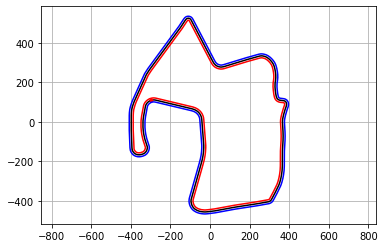

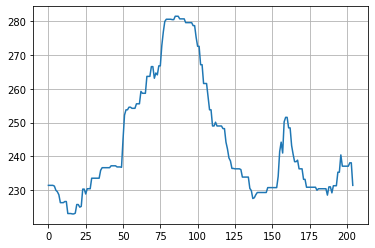

In [21]:
plt.plot(ls_df["x"], ls_df["y"], 'k')
plt.plot(ls_df["x"][0], ls_df["y"][0], 'r.')
plt.plot(ls_df["inner_x"], ls_df["inner_y"], 'r')
plt.plot(ls_df["outer_x"], ls_df["outer_y"], 'b')


plt.axis('equal')
plt.grid()
plt.show()

plt.plot(ls_df["z"])
plt.grid()

In [25]:
out_df = pd.DataFrame()
out_df["x"] = ls_df["x"] - ls_df["x"][0]
out_df["y"] = ls_df["y"] - ls_df["y"][0]
out_df["z"] = ls_df["z"] - ls_df["z"][0]
out_df["xn"] = ls_df["next_x"] - ls_df["x"][0]
out_df["yn"] = ls_df["next_y"] - ls_df["y"][0]
out_df["zn"] = ls_df["next_z"] - ls_df["z"][0]
out_df['heading'] = ls_df['bearing_to_next']
out_df["dist"] = ls_df["dist_to_next"]
out_df["uv"] = ls_df["uv_to_next"]
out_df["cum_dist"] = ls_df["cum_distance"] - ls_df["cum_distance"][0]
out_df["inner_x"] = ls_df["inner_x"] - ls_df["x"][0]
out_df["inner_y"] = ls_df["inner_y"] - ls_df["y"][0]
out_df["outer_x"] = ls_df["outer_x"] - ls_df["x"][0]
out_df["outer_y"] = ls_df["outer_y"] - ls_df["y"][0]


out_df.to_csv("C:/Users/sgtas/Desktop/autonomous_car/track_data.csv", index=False)